## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
import hw

## Load data

In [4]:
cropped_data_dir = 'data/CroppedYale/'
cropped = hw.LoadCropped(cropped_data_dir)

In [5]:
X             = cropped.X
y             = cropped.y
h             = cropped.h
w             = cropped.w
target_names  = cropped.target_names
n_samples     = cropped.n_samples
n_features    = cropped.n_features
n_classes     = cropped.n_classes

## Split into training and test data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Compute rank r truncation

In [7]:
U,S,VT = np.linalg.svd(X_train.T,full_matrices=0) 

In [8]:
var_explained = np.round(S**2/np.sum(S**2), decimals=100)
thresh = 0.99
cdf=np.cumsum(var_explained)
n_components = np.where(cdf>thresh)[0][0]
n_components

136

## Compute eigenfaces and project images into subspace

In [9]:
pca = PCA(n_components=n_components, 
          svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Model Comparison

### Support Vector Classification with Radial Basis Function

In [10]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

model = SVC(kernel='rbf', class_weight='balanced')

In [11]:
clf_svm_rbf = GridSearchCV(model, param_grid)
clf_svm_rbf = clf_svm_rbf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_svm_rbf.best_estimator_)
print("Score: %0.2f" % clf_svm_rbf.best_score_)

Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Score: 0.94


In [12]:
df = pd.DataFrame(clf_svm_rbf.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                             0.781954
std_fit_time                              0.135168
mean_score_time                           0.103448
std_score_time                           0.0204982
param_C                                       1000
param_gamma                                  0.005
params               {'C': 1000.0, 'gamma': 0.005}
split0_test_score                         0.933702
split1_test_score                          0.91989
split2_test_score                         0.947514
split3_test_score                         0.953039
split4_test_score                         0.941989
mean_test_score                           0.939227
std_test_score                            0.011589
rank_test_score                                  1
Name: 3, dtype: object

In [13]:
y_pred_svm_rbf  = clf_svm_rbf.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm_rbf, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       0.85      1.00      0.92        11
     yaleB02       0.80      0.80      0.80        15
     yaleB03       0.94      1.00      0.97        15
     yaleB04       0.92      1.00      0.96        23
     yaleB05       0.95      0.90      0.92        20
     yaleB06       1.00      0.87      0.93        15
     yaleB07       0.91      1.00      0.95        21
     yaleB08       1.00      0.79      0.88        19
     yaleB09       1.00      0.87      0.93        15
     yaleB10       1.00      0.89      0.94        19
     yaleB11       1.00      0.93      0.97        15
     yaleB12       1.00      1.00      1.00        11
     yaleB13       0.93      0.93      0.93        14
     yaleB15       1.00      0.93      0.96        14
     yaleB16       0.91      0.91      0.91        11
     yaleB17       1.00      0.90      0.95        10
     yaleB18       1.00      1.00      1.00        16
     yaleB19       1.00    

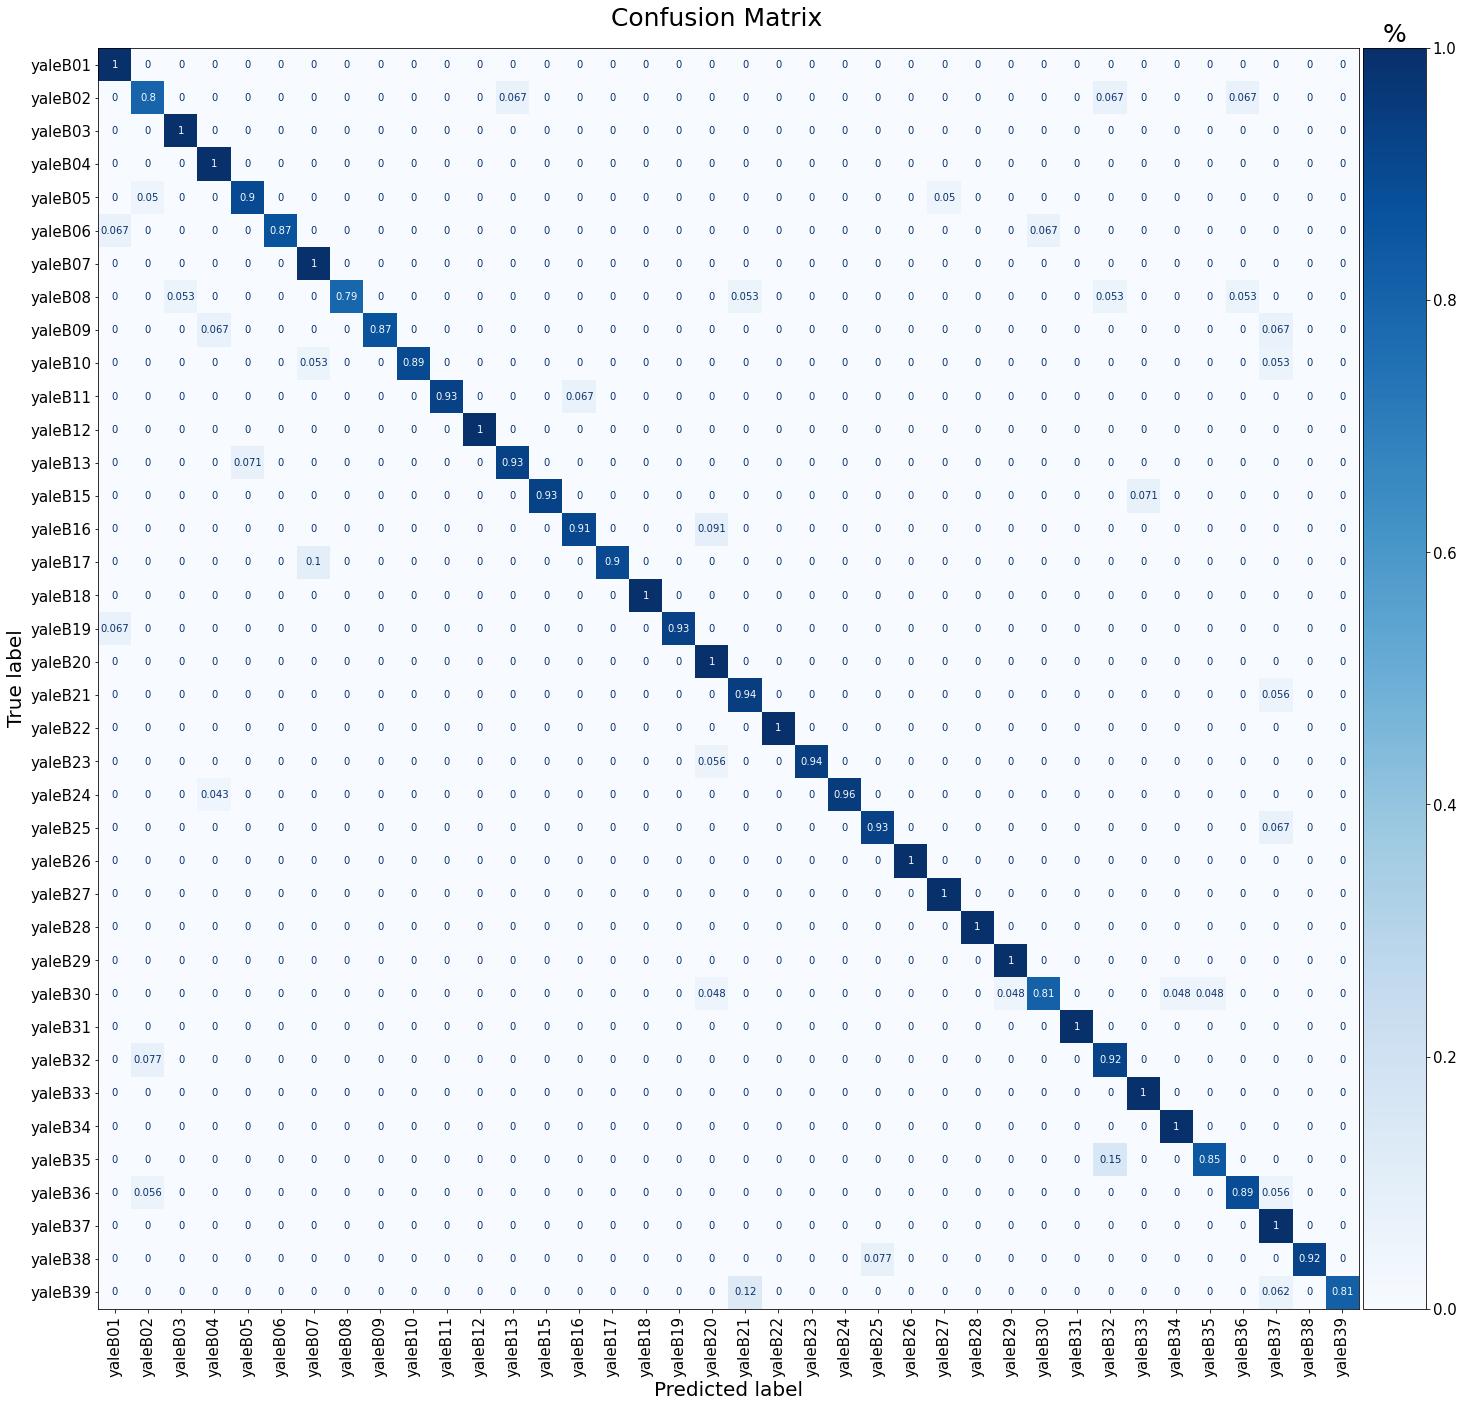

In [14]:
clf = clf_svm_rbf
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Support Vector Classification with Linear Decision Boundaries

In [15]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

model = SVC(kernel='linear', class_weight='balanced')

In [16]:
clf_svm_ln = GridSearchCV(model, param_grid)
clf_svm_ln = clf_svm_ln.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_svm_ln.best_estimator_)
print("Score: %0.2f" % clf_svm_ln.best_score_)

Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Score: 0.91


In [17]:
df = pd.DataFrame(clf_svm_ln.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                               1.14221
std_fit_time                              0.0602775
mean_score_time                            0.295408
std_score_time                            0.0789293
param_C                                        1000
param_gamma                                  0.0001
params               {'C': 1000.0, 'gamma': 0.0001}
split0_test_score                           0.90884
split1_test_score                           0.89779
split2_test_score                           0.91989
split3_test_score                          0.922652
split4_test_score                          0.917127
mean_test_score                             0.91326
std_test_score                           0.00901078
rank_test_score                                   1
Name: 0, dtype: object

In [18]:
y_pred_svm_ln  = clf_svm_ln.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm_ln, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       0.85      1.00      0.92        11
     yaleB02       0.86      0.80      0.83        15
     yaleB03       0.88      1.00      0.94        15
     yaleB04       0.85      1.00      0.92        23
     yaleB05       0.94      0.85      0.89        20
     yaleB06       1.00      0.87      0.93        15
     yaleB07       0.91      0.95      0.93        21
     yaleB08       0.93      0.74      0.82        19
     yaleB09       0.93      0.87      0.90        15
     yaleB10       0.94      0.89      0.92        19
     yaleB11       1.00      0.93      0.97        15
     yaleB12       1.00      1.00      1.00        11
     yaleB13       0.71      0.86      0.77        14
     yaleB15       1.00      0.93      0.96        14
     yaleB16       0.91      0.91      0.91        11
     yaleB17       1.00      0.90      0.95        10
     yaleB18       1.00      1.00      1.00        16
     yaleB19       0.93    

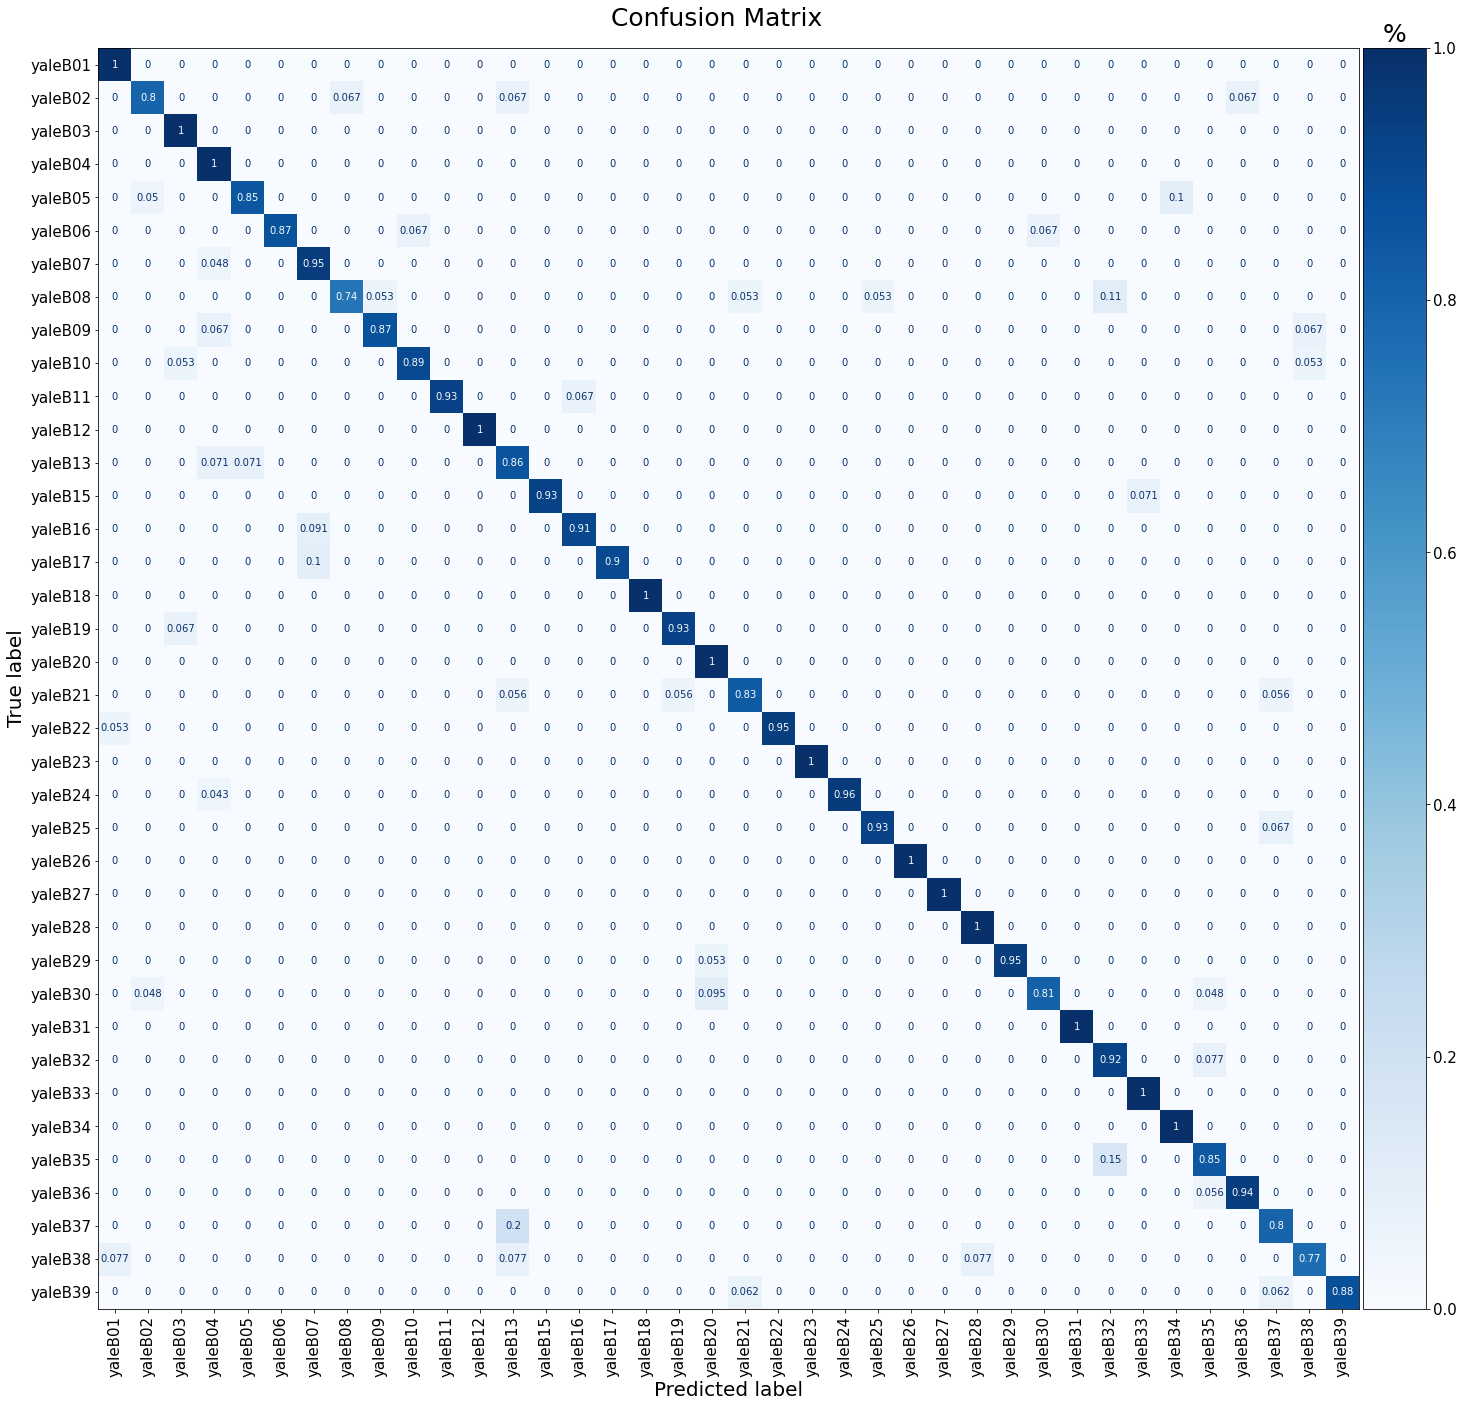

In [19]:
clf = clf_svm_ln
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Gaussian Naive Bayes

In [20]:
param_grid = {'var_smoothing': [1e-10, 1e-09, 1e-08], }

model = GaussianNB()

In [21]:
clf_gnb = GridSearchCV(model, param_grid)
clf_gnb = clf_gnb.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_gnb.best_estimator_)
print("Score: %0.2f" % clf_gnb.best_score_)

Best estimator found by grid search:
GaussianNB(priors=None, var_smoothing=1e-10)
Score: 0.84


In [22]:
df = pd.DataFrame(clf_gnb.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                         0.0083869
std_fit_time                         0.00121476
mean_score_time                       0.0165894
std_score_time                      0.000936601
param_var_smoothing                       1e-10
params                 {'var_smoothing': 1e-10}
split0_test_score                      0.820442
split1_test_score                      0.834254
split2_test_score                      0.853591
split3_test_score                      0.875691
split4_test_score                      0.837017
mean_test_score                        0.844199
std_test_score                        0.0189463
rank_test_score                               1
Name: 0, dtype: object

In [23]:
y_pred_gnb  = clf_gnb.predict(X_test_pca)
print(classification_report(y_test, y_pred_gnb, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       0.85      1.00      0.92        11
     yaleB02       0.92      0.80      0.86        15
     yaleB03       0.87      0.87      0.87        15
     yaleB04       0.95      0.91      0.93        23
     yaleB05       1.00      0.85      0.92        20
     yaleB06       1.00      0.80      0.89        15
     yaleB07       0.88      0.71      0.79        21
     yaleB08       0.92      0.63      0.75        19
     yaleB09       0.93      0.87      0.90        15
     yaleB10       0.89      0.84      0.86        19
     yaleB11       0.93      0.87      0.90        15
     yaleB12       1.00      1.00      1.00        11
     yaleB13       0.57      0.93      0.70        14
     yaleB15       0.92      0.86      0.89        14
     yaleB16       0.75      0.82      0.78        11
     yaleB17       0.60      0.90      0.72        10
     yaleB18       0.94      1.00      0.97        16
     yaleB19       0.86    

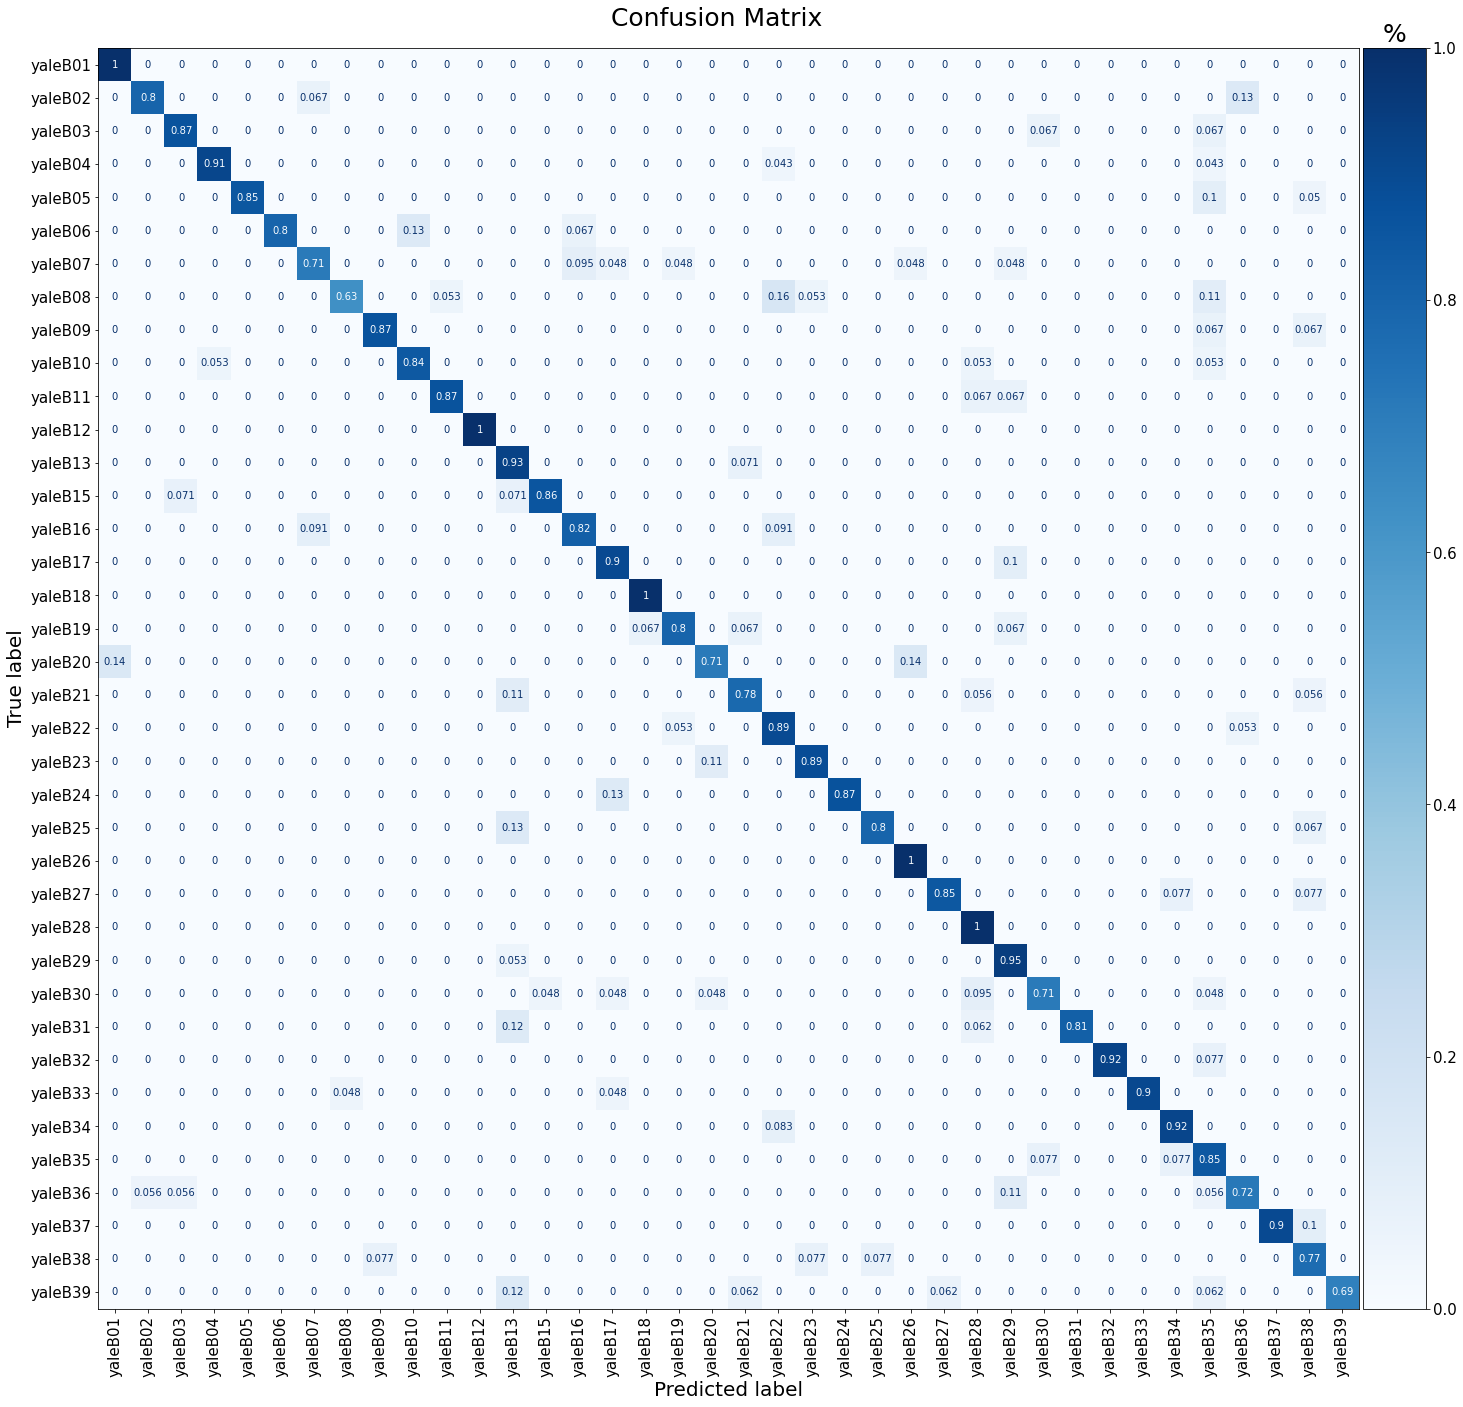

In [24]:
clf = clf_gnb
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### K-Nearest Neighbors

In [25]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 2, 3, 5, 10, 50], }

model = KNeighborsClassifier(n_jobs=-1)

In [26]:
clf_knn = GridSearchCV(model, param_grid)
clf_knn = clf_knn.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_knn.best_estimator_)
print("Score: %0.2f" % clf_knn.best_score_)

Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')
Score: 0.92


In [27]:
df = pd.DataFrame(clf_knn.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                      0.00944438
std_fit_time                                       0.00105999
mean_score_time                                      0.427452
std_score_time                                       0.665571
param_n_neighbors                                           1
param_weights                                         uniform
params               {'n_neighbors': 1, 'weights': 'uniform'}
split0_test_score                                    0.900552
split1_test_score                                    0.914365
split2_test_score                                    0.917127
split3_test_score                                    0.930939
split4_test_score                                     0.91989
mean_test_score                                      0.916575
std_test_score                                     0.00979008
rank_test_score                                             1
Name: 0, dtype: object

In [28]:
y_pred_knn  = clf_knn.predict(X_test_pca)
print(classification_report(y_test, y_pred_knn, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       0.85      1.00      0.92        11
     yaleB02       0.93      0.87      0.90        15
     yaleB03       1.00      0.87      0.93        15
     yaleB04       0.96      1.00      0.98        23
     yaleB05       1.00      0.75      0.86        20
     yaleB06       1.00      0.80      0.89        15
     yaleB07       0.80      0.95      0.87        21
     yaleB08       0.93      0.68      0.79        19
     yaleB09       0.93      0.87      0.90        15
     yaleB10       1.00      0.84      0.91        19
     yaleB11       1.00      0.87      0.93        15
     yaleB12       1.00      0.91      0.95        11
     yaleB13       0.93      0.93      0.93        14
     yaleB15       1.00      0.93      0.96        14
     yaleB16       1.00      0.91      0.95        11
     yaleB17       1.00      0.90      0.95        10
     yaleB18       1.00      1.00      1.00        16
     yaleB19       0.87    

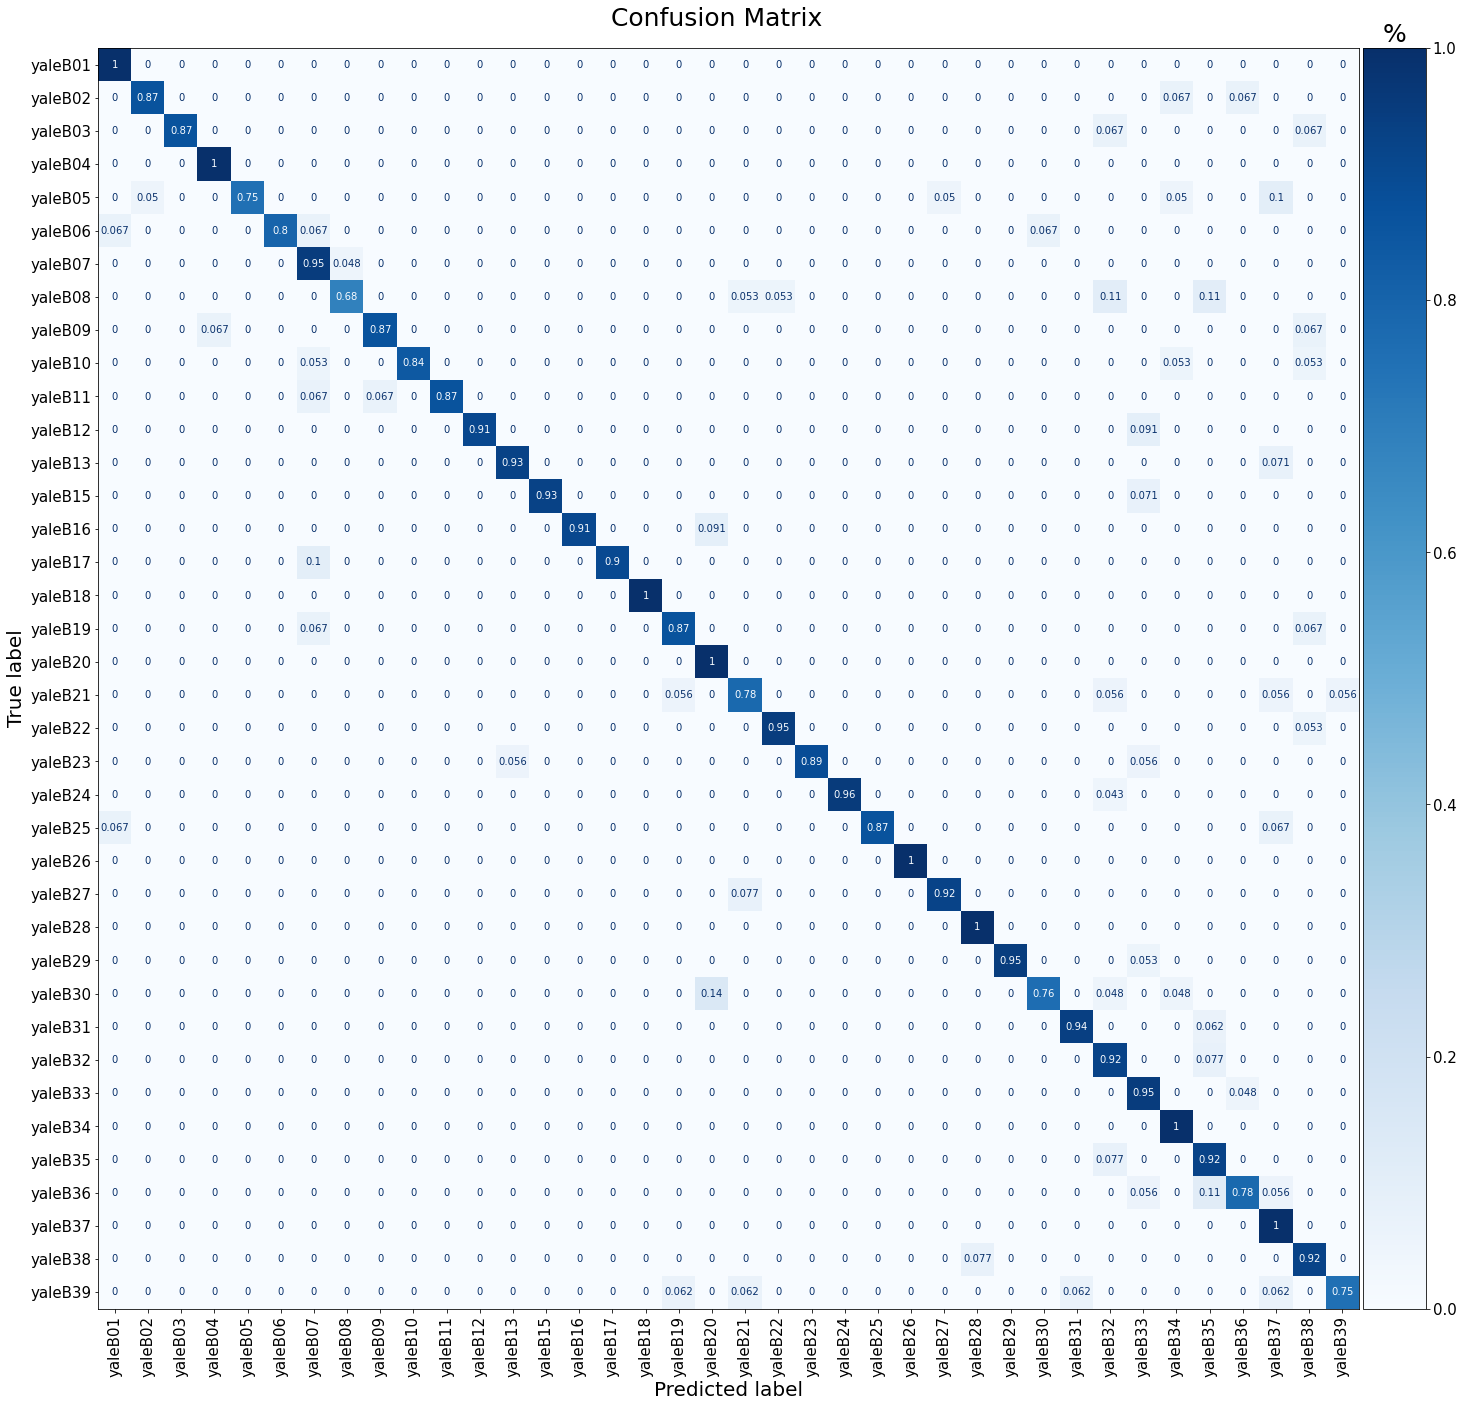

In [29]:
clf = clf_knn
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Decision Tree

In [30]:
param_grid = {'max_depth': [None, 50, 100, 150, 200, 1000],
              'criterion': ['gini', 'entropy']}

model = DecisionTreeClassifier()

In [31]:
clf_dtc = GridSearchCV(model, param_grid)
clf_dtc = clf_dtc.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_dtc.best_estimator_)
print("Score: %0.2f" % clf_dtc.best_score_)

Best estimator found by grid search:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=1000, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Score: 0.51


In [32]:
df = pd.DataFrame(clf_dtc.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                              1.706
std_fit_time                                           0.0648998
mean_score_time                                      0.000922871
std_score_time                                       7.23138e-05
param_criterion                                          entropy
param_max_depth                                             1000
params               {'criterion': 'entropy', 'max_depth': 1000}
split0_test_score                                       0.477901
split1_test_score                                       0.480663
split2_test_score                                       0.530387
split3_test_score                                       0.513812
split4_test_score                                       0.533149
mean_test_score                                         0.507182
std_test_score                                         0.0237376
rank_test_score                                                1
Name: 11, dtype: object

In [33]:
y_pred_dtc  = clf_dtc.predict(X_test_pca)
print(classification_report(y_test, y_pred_dtc, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       0.38      0.45      0.42        11
     yaleB02       0.57      0.87      0.68        15
     yaleB03       0.70      0.47      0.56        15
     yaleB04       0.54      0.61      0.57        23
     yaleB05       0.75      0.45      0.56        20
     yaleB06       0.50      0.53      0.52        15
     yaleB07       0.40      0.38      0.39        21
     yaleB08       0.73      0.42      0.53        19
     yaleB09       0.45      0.60      0.51        15
     yaleB10       0.45      0.53      0.49        19
     yaleB11       0.56      0.60      0.58        15
     yaleB12       0.60      0.55      0.57        11
     yaleB13       0.44      0.50      0.47        14
     yaleB15       0.80      0.57      0.67        14
     yaleB16       0.40      0.36      0.38        11
     yaleB17       0.42      0.50      0.45        10
     yaleB18       0.62      0.50      0.55        16
     yaleB19       0.63    

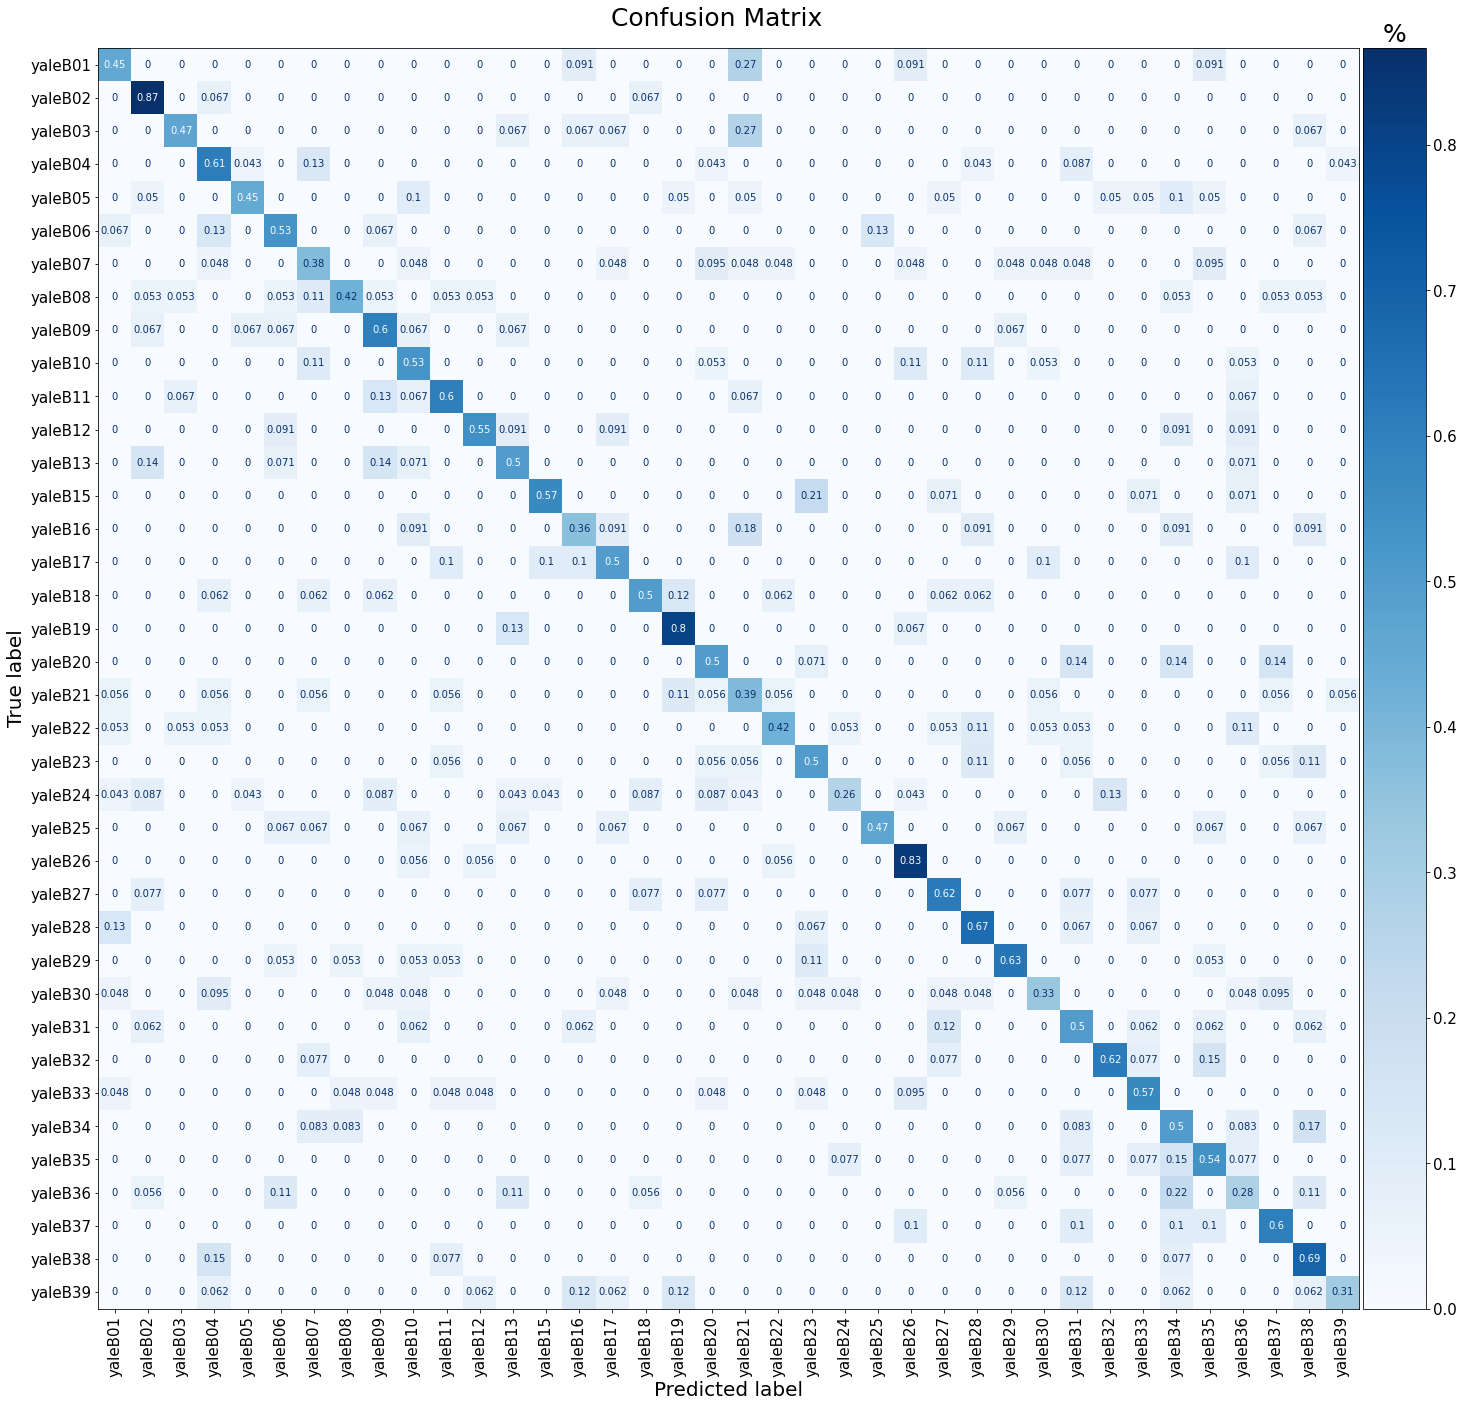

In [34]:
clf = clf_dtc
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Random Forest 

In [35]:
param_grid = {'max_depth': [None, 50, 100, 150, 200, 1000],
              'n_estimators': [1, 5, 10, 50, 100, 200],
              'criterion': ['gini', 'entropy']}

model = RandomForestClassifier(n_jobs=-1)

In [36]:
clf_rfc = GridSearchCV(model, param_grid)
clf_rfc = clf_rfc.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_rfc.best_estimator_)
print("Score: %0.2f" % clf_rfc.best_score_)

Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Score: 0.92


In [55]:
df = pd.DataFrame(clf_rfc.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                                   2.29296
std_fit_time                                                   0.218913
mean_score_time                                                0.109003
std_score_time                                                0.0107545
param_criterion                                                    gini
param_max_depth                                                     200
param_n_estimators                                                  200
params                {'criterion': 'gini', 'max_depth': 200, 'n_est...
split0_test_score                                               0.90884
split1_test_score                                              0.903315
split2_test_score                                              0.911602
split3_test_score                                              0.930939
split4_test_score                                              0.928177
mean_test_score                                                0

In [38]:
y_pred_rfc  = clf_dtc.predict(X_test_pca)
print(classification_report(y_test, y_pred_rfc, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       0.38      0.45      0.42        11
     yaleB02       0.57      0.87      0.68        15
     yaleB03       0.70      0.47      0.56        15
     yaleB04       0.54      0.61      0.57        23
     yaleB05       0.75      0.45      0.56        20
     yaleB06       0.50      0.53      0.52        15
     yaleB07       0.40      0.38      0.39        21
     yaleB08       0.73      0.42      0.53        19
     yaleB09       0.45      0.60      0.51        15
     yaleB10       0.45      0.53      0.49        19
     yaleB11       0.56      0.60      0.58        15
     yaleB12       0.60      0.55      0.57        11
     yaleB13       0.44      0.50      0.47        14
     yaleB15       0.80      0.57      0.67        14
     yaleB16       0.40      0.36      0.38        11
     yaleB17       0.42      0.50      0.45        10
     yaleB18       0.62      0.50      0.55        16
     yaleB19       0.63    

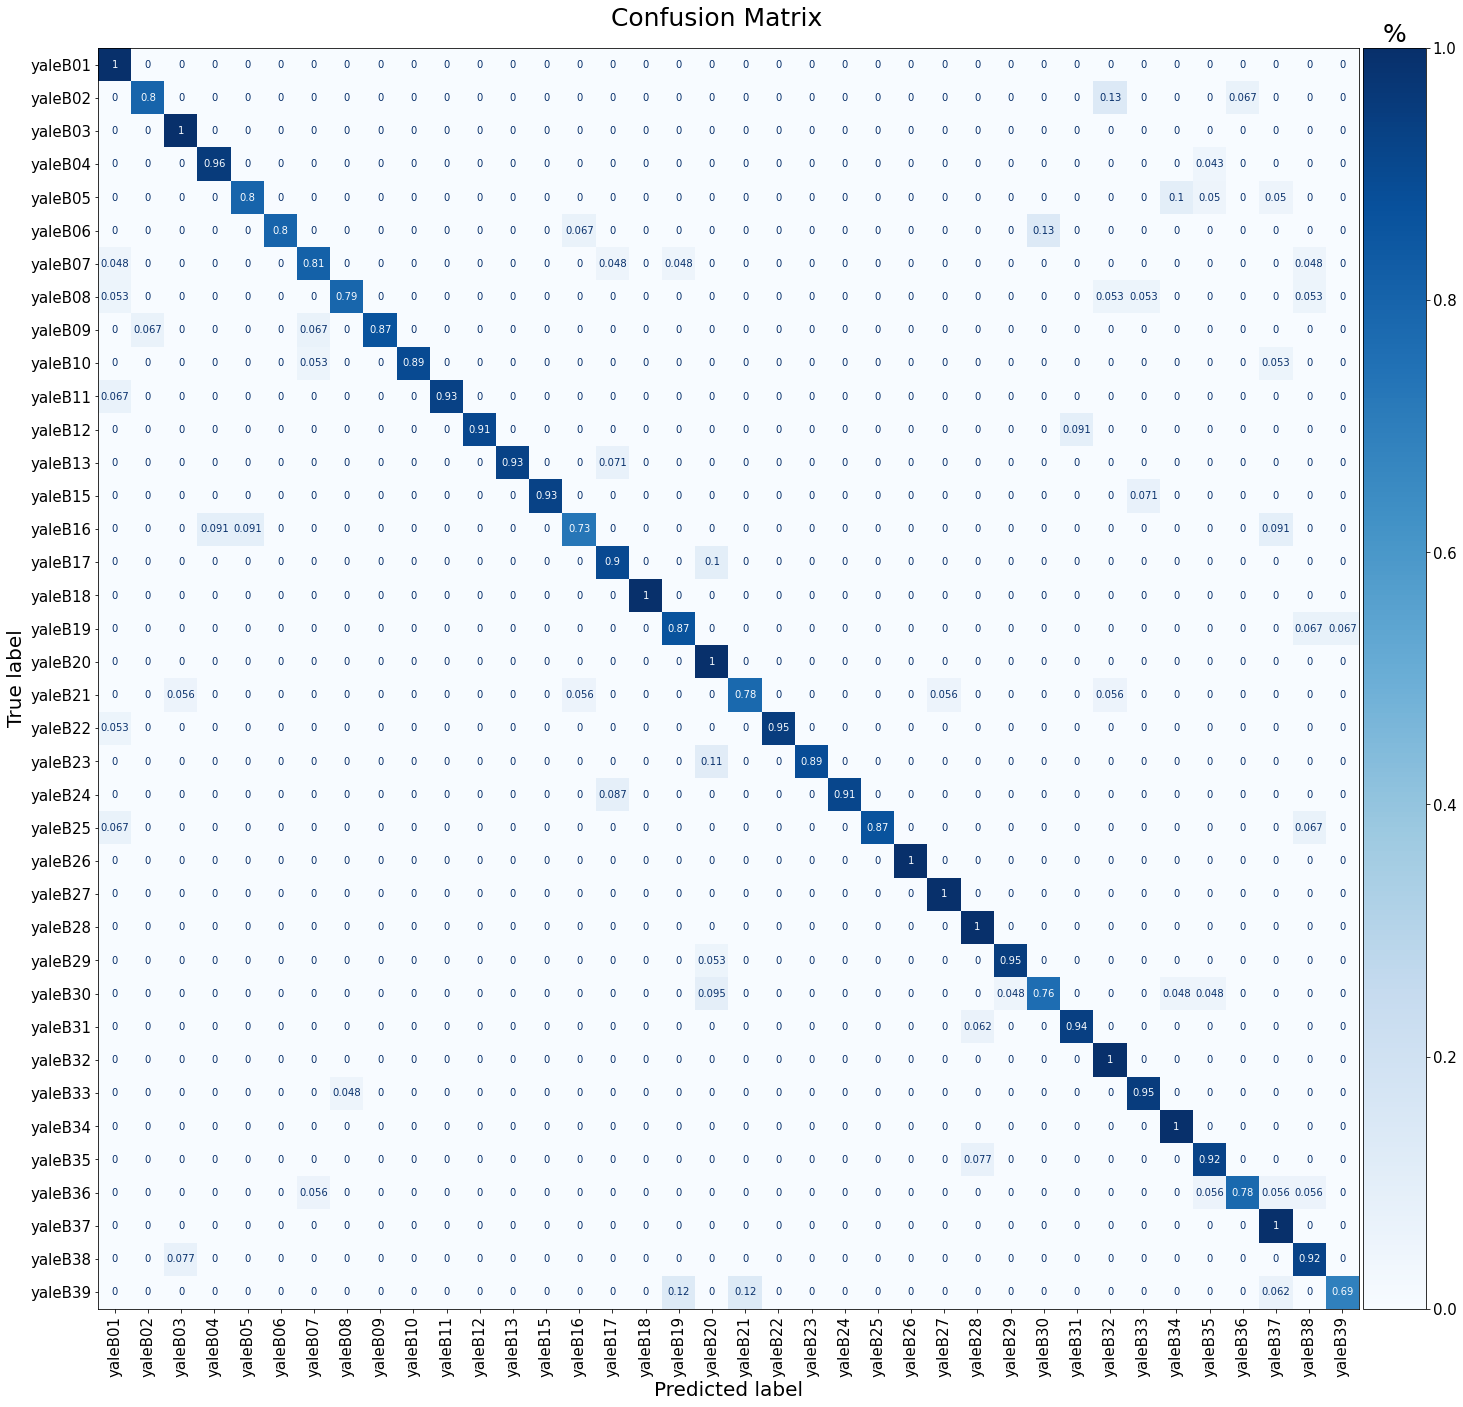

In [39]:
clf = clf_rfc
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Adaboost

In [40]:
param_grid = {'n_estimators': [1, 5, 10, 50, 100, 200],
             'learning_rate': [0.001, 0.1, 1]}

model = AdaBoostClassifier()

In [41]:
clf_adab = GridSearchCV(model, param_grid)
clf_adab = clf_adab.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_adab.best_estimator_)
print("Score: %0.2f" % clf_adab.best_score_)

Best estimator found by grid search:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=200, random_state=None)
Score: 0.45


In [42]:
df = pd.DataFrame(clf_adab.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                              7.26567
std_fit_time                                             0.0726781
mean_score_time                                           0.107841
std_score_time                                          0.00787667
param_learning_rate                                            0.1
param_n_estimators                                             200
params                 {'learning_rate': 0.1, 'n_estimators': 200}
split0_test_score                                          0.41989
split1_test_score                                         0.422652
split2_test_score                                          0.41989
split3_test_score                                         0.461326
split4_test_score                                         0.530387
mean_test_score                                           0.450829
std_test_score                                            0.042774
rank_test_score                                               

In [43]:
y_pred_adab  = clf_adab.predict(X_test_pca)
print(classification_report(y_test, y_pred_adab, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       0.36      0.82      0.50        11
     yaleB02       0.33      0.07      0.11        15
     yaleB03       0.79      0.73      0.76        15
     yaleB04       0.39      0.48      0.43        23
     yaleB05       0.91      0.50      0.65        20
     yaleB06       1.00      0.20      0.33        15
     yaleB07       0.33      0.29      0.31        21
     yaleB08       0.50      0.11      0.17        19
     yaleB09       1.00      0.07      0.12        15
     yaleB10       0.35      0.37      0.36        19
     yaleB11       1.00      0.13      0.24        15
     yaleB12       0.50      0.09      0.15        11
     yaleB13       1.00      0.29      0.44        14
     yaleB15       1.00      0.07      0.13        14
     yaleB16       0.71      0.45      0.56        11
     yaleB17       0.18      0.30      0.22        10
     yaleB18       0.83      0.31      0.45        16
     yaleB19       0.50    

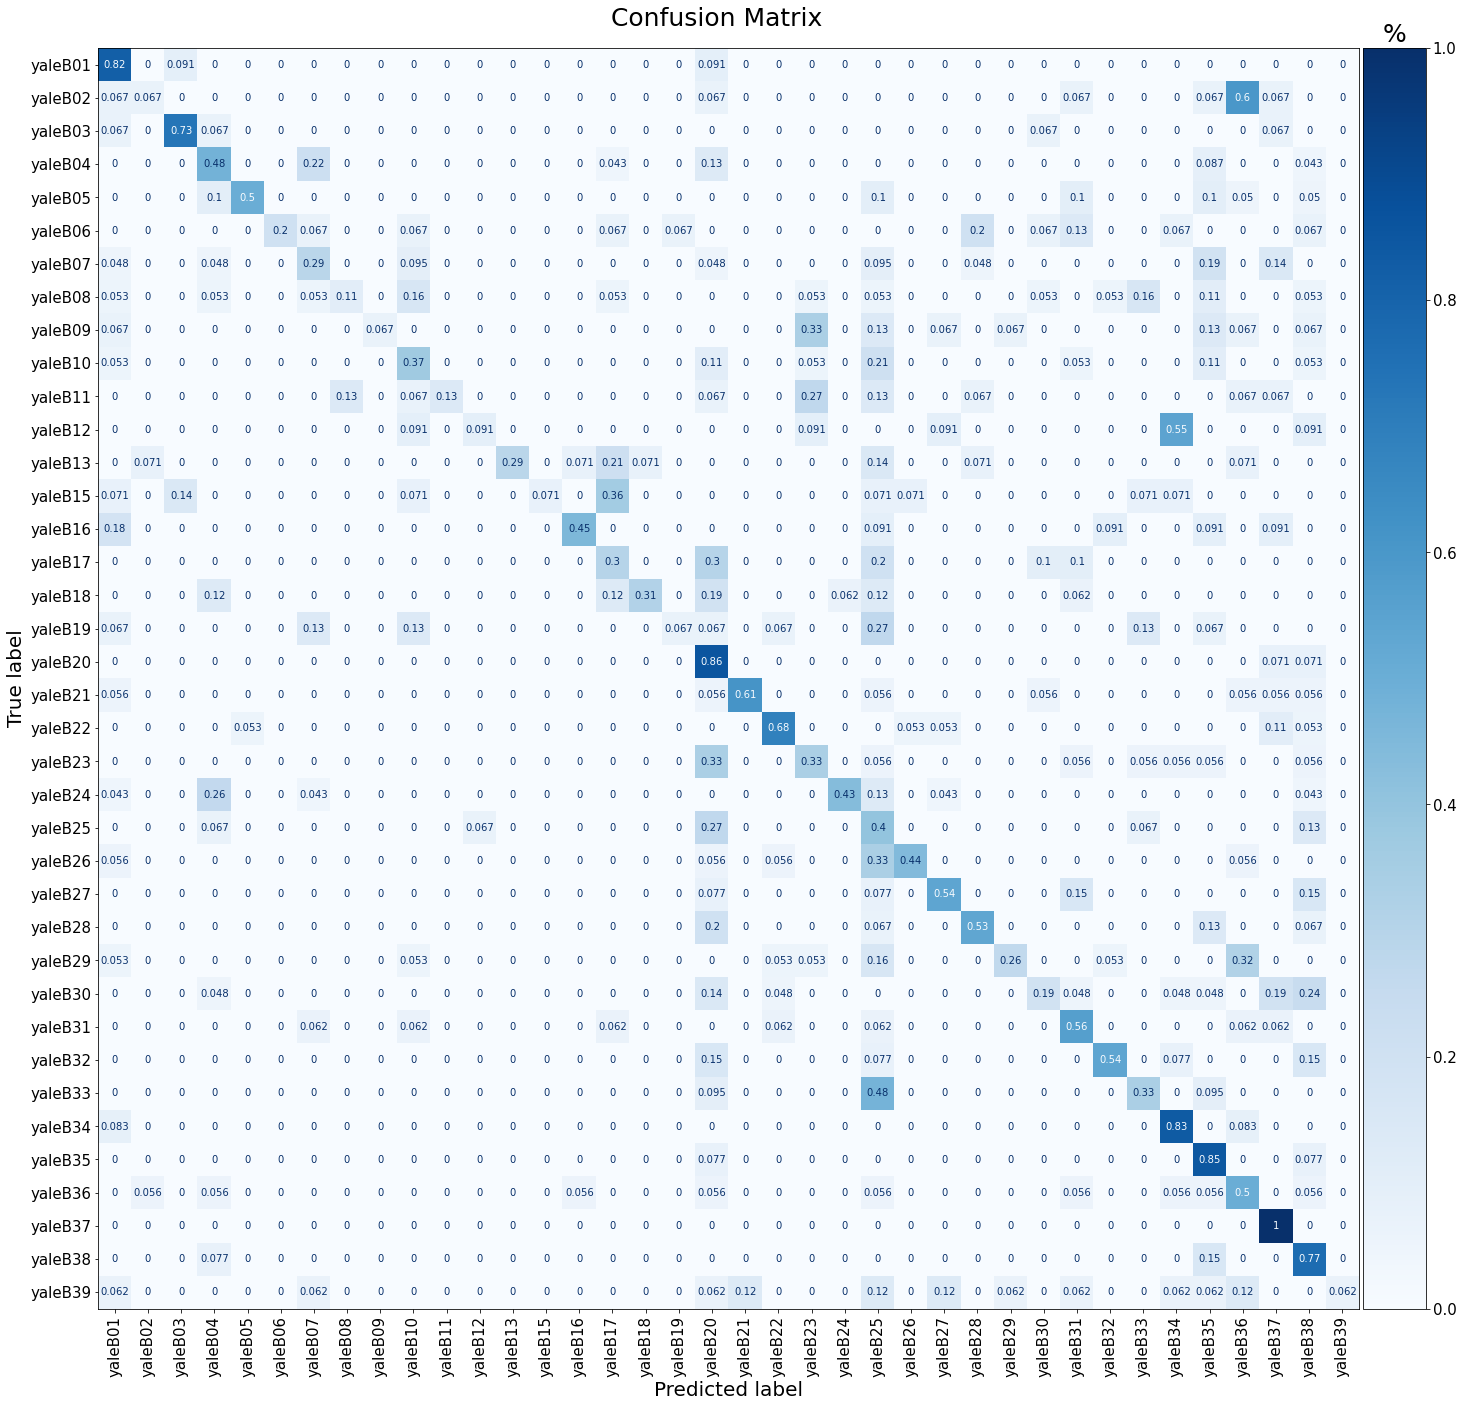

In [44]:
clf = clf_adab
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Linear Discriminant Analysis

In [45]:
param_grid = {'tol': [0.0001, 0.001, 0.01, 0.1, 1]}

model = LinearDiscriminantAnalysis()

In [46]:
clf_lda = GridSearchCV(model, param_grid)
clf_lda = clf_lda.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_lda.best_estimator_)
print("Score: %0.2f" % clf_lda.best_score_)

Best estimator found by grid search:
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Score: 0.91


In [47]:
df = pd.DataFrame(clf_lda.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time              0.0706675
std_fit_time               0.0100283
mean_score_time           0.00093503
std_score_time           0.000153298
param_tol                     0.0001
params               {'tol': 0.0001}
split0_test_score           0.903315
split1_test_score           0.892265
split2_test_score           0.917127
split3_test_score           0.922652
split4_test_score           0.922652
mean_test_score             0.911602
std_test_score             0.0119776
rank_test_score                    1
Name: 0, dtype: object

In [48]:
y_pred_lda  = clf_lda.predict(X_test_pca)
print(classification_report(y_test, y_pred_lda, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       1.00      1.00      1.00        11
     yaleB02       1.00      0.80      0.89        15
     yaleB03       1.00      0.93      0.97        15
     yaleB04       0.74      1.00      0.85        23
     yaleB05       1.00      0.80      0.89        20
     yaleB06       1.00      0.73      0.85        15
     yaleB07       1.00      1.00      1.00        21
     yaleB08       1.00      0.74      0.85        19
     yaleB09       1.00      0.87      0.93        15
     yaleB10       0.94      0.89      0.92        19
     yaleB11       1.00      1.00      1.00        15
     yaleB12       1.00      1.00      1.00        11
     yaleB13       1.00      0.93      0.96        14
     yaleB15       1.00      0.86      0.92        14
     yaleB16       1.00      0.91      0.95        11
     yaleB17       1.00      1.00      1.00        10
     yaleB18       1.00      1.00      1.00        16
     yaleB19       1.00    

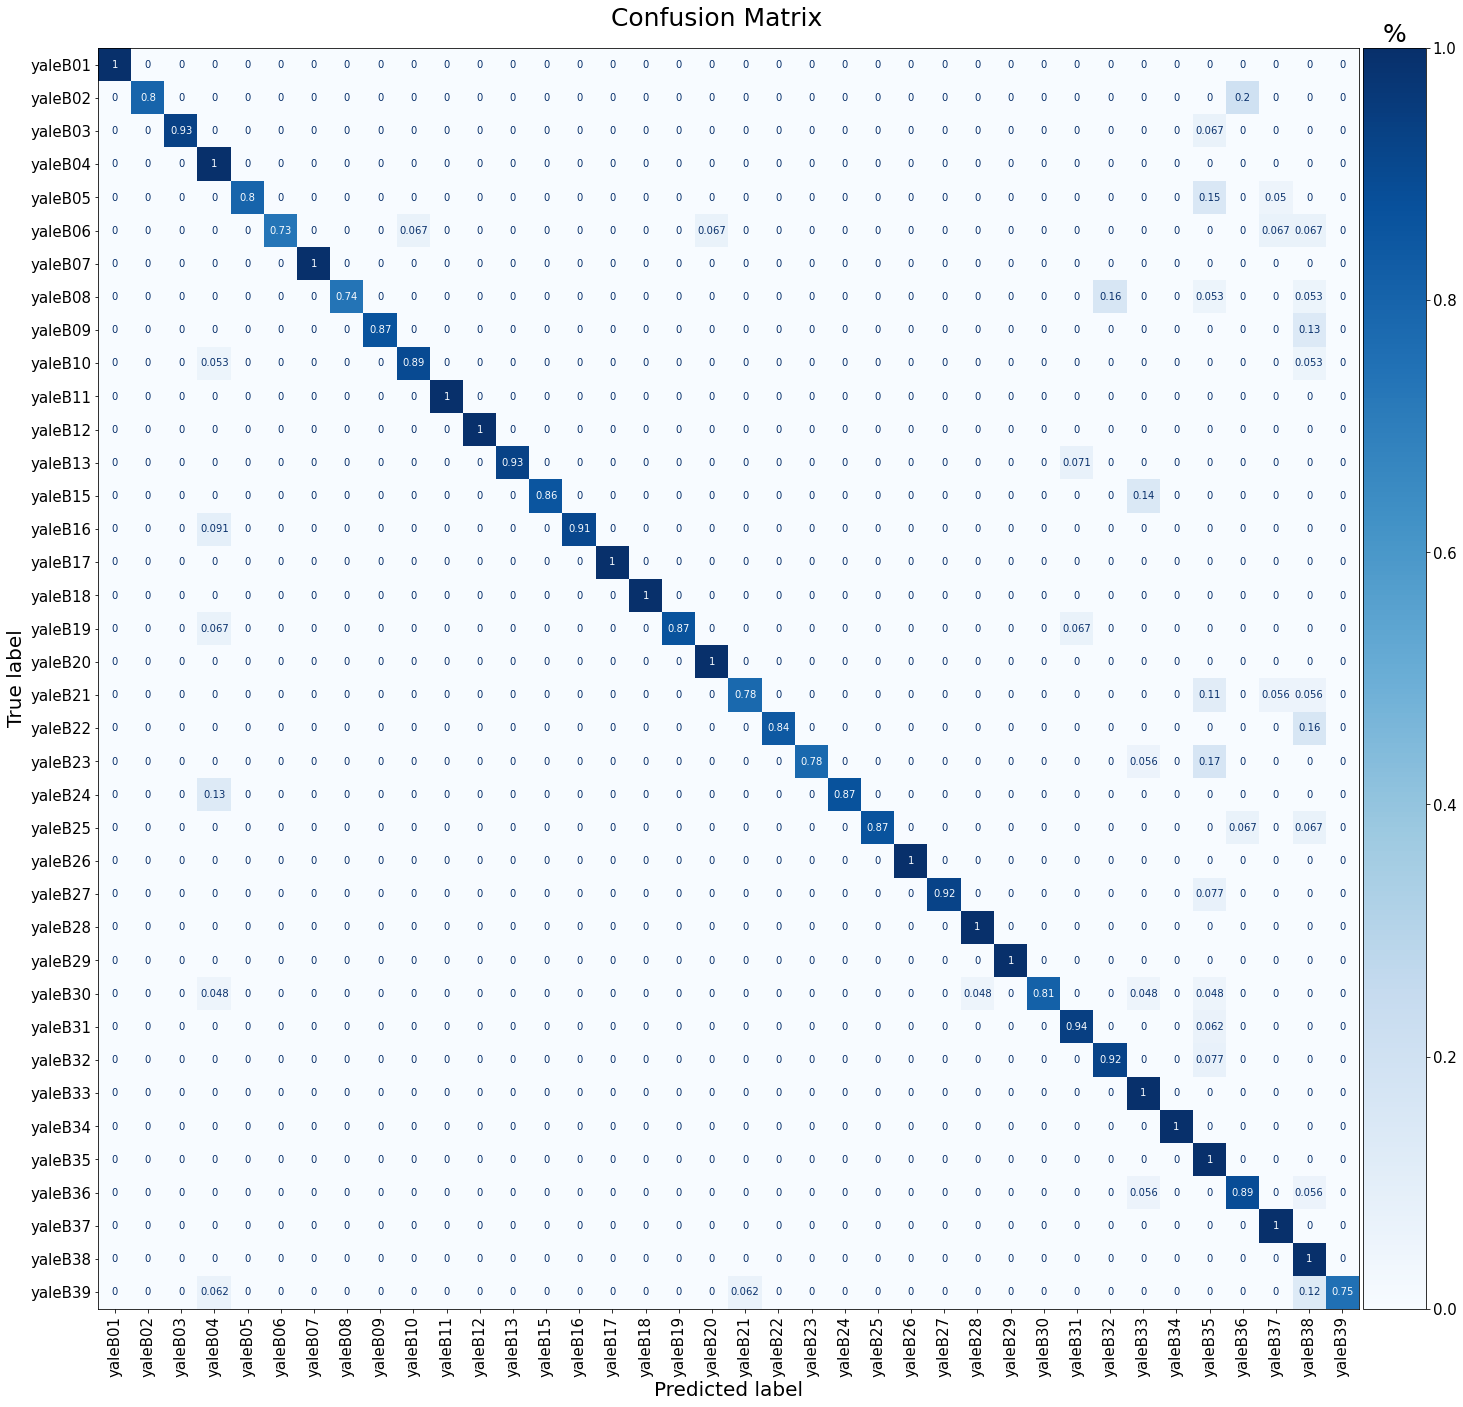

In [49]:
clf = clf_lda
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Quadratic Discriminant Analysis

In [50]:
param_grid = {'tol': [0.0001, 0.001, 0.01, 0.1, 1],
              'reg_param': [1, 0.0, 0.001, 0.0001]}

model = QuadraticDiscriminantAnalysis()

In [51]:
clf_qda = GridSearchCV(model, param_grid)
clf_qda = clf_qda.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_qda.best_estimator_)
print("Score: %0.2f" % clf_qda.best_score_)

Best estimator found by grid search:
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.001,
                              store_covariance=False, tol=0.0001)
Score: 0.56


In [52]:
df = pd.DataFrame(clf_qda.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                  0.0984291
std_fit_time                                  0.00964211
mean_score_time                                0.0182967
std_score_time                               0.000736679
param_reg_param                                    0.001
param_tol                                         0.0001
params               {'reg_param': 0.001, 'tol': 0.0001}
split0_test_score                               0.491713
split1_test_score                               0.552486
split2_test_score                               0.582873
split3_test_score                                0.58011
split4_test_score                               0.571823
mean_test_score                                 0.555801
std_test_score                                 0.0337605
rank_test_score                                        1
Name: 10, dtype: object

In [53]:
y_pred_qda  = clf_qda.predict(X_test_pca)
print(classification_report(y_test, y_pred_qda, target_names=target_names))

              precision    recall  f1-score   support

     yaleB01       1.00      0.64      0.78        11
     yaleB02       1.00      0.53      0.70        15
     yaleB03       0.85      0.73      0.79        15
     yaleB04       0.95      0.78      0.86        23
     yaleB05       0.78      0.70      0.74        20
     yaleB06       0.90      0.60      0.72        15
     yaleB07       1.00      0.52      0.69        21
     yaleB08       1.00      0.42      0.59        19
     yaleB09       1.00      0.53      0.70        15
     yaleB10       0.41      0.74      0.53        19
     yaleB11       0.85      0.73      0.79        15
     yaleB12       0.82      0.82      0.82        11
     yaleB13       0.28      0.79      0.41        14
     yaleB15       0.80      0.86      0.83        14
     yaleB16       0.67      0.55      0.60        11
     yaleB17       1.00      0.60      0.75        10
     yaleB18       0.87      0.81      0.84        16
     yaleB19       0.89    

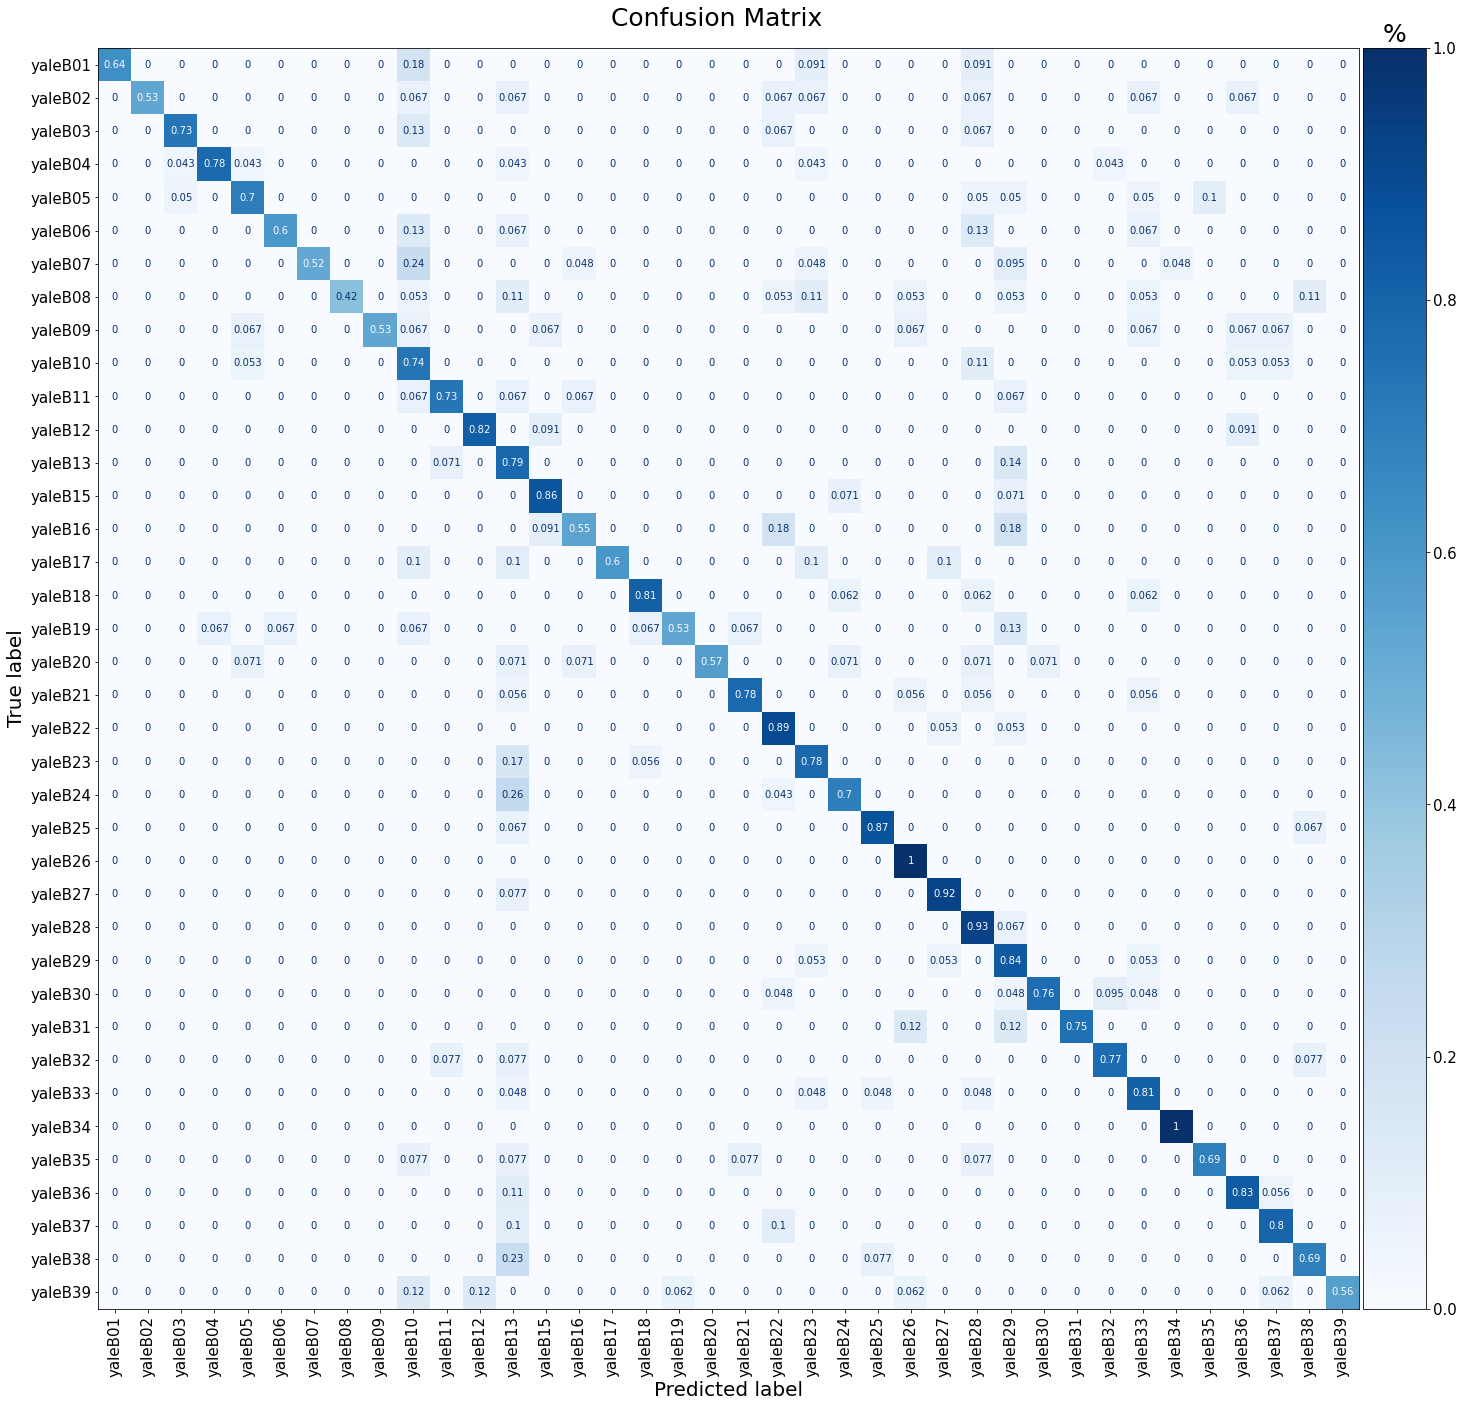

In [54]:
clf = clf_qda
fig,ax = plt.subplots(figsize=(20,20))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

## References

https://scikit-learn.org/0.16/auto_examples/classification/plot_classifier_comparison.html  
https://www.youtube.com/watch?v=epoHE2rex0g&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=36  
https://ieeexplore.ieee.org/document/6846297